# A First Predictive Modeling Project

In this notebook we will use the simple linear regression model to demonstrate the process of predictive model selection in a vaguely realistic scenario. 

## What we will accomplish

In particular we will:
- Review some of the common steps in a predictive modeling project,
- Work with a baseball data set,
- Introduce the concept of a baseline model and
- Practice implementing cross-validation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

Common steps in a predictive modeling project include:

1. Data Gathering, defining stakeholders and KPIs
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis
4. Compare different models on the training set
5. Final sanity check on test set

## Example: A baseball regression problem

#### Step 1. Data Gathering, defining stakeholders and KPIs

Let's imagine we work for a major league baseball team in the off-season. During the off-season teams are looking to see what players they can bring in to improve upon their number of wins in the coming season.

A reasonable question is whether stocking up on good defensive players (limiting the number of runs your team allows) or stocking up on good offensive players (increasing the number of runs your teams scores) is better at predicting the number of wins you will have in a given season. We could use existing projections for each player to estimate our number of runs scores and runs allowed after acquiring said player to predict our expected wins.

In this problem we will do just that. First let's load the data.

In [2]:
## Note this works on Mac and Linux,
## you may need to change the slash directions if
## you are running a Windows machine
baseball = pd.read_csv("../../data/baseball.csv")

In [3]:
baseball.sample(5, random_state=234)

,teamID,yearID,lgID,G,W,L,R,RA
351,PIT,2012,NL,162,79,83,651,674
189,DET,2007,AL,162,88,74,887,797
319,OAK,2011,AL,162,74,88,645,679
31,ARI,2002,NL,162,98,64,819,674
318,NYN,2011,NL,162,77,85,718,742


This data set contains the wins (`W`), losses (`L`), runs scored (`R`) and runs allowed (`RA`) for each team (`teamID`) over the 2001-2018 seasons (`yearID`).

#### Step 2:  Data Cleaning and Preprocessing

Check to make sure we don't have any missing values, etc

In [4]:
baseball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teamID  540 non-null    object
 1   yearID  540 non-null    int64 
 2   lgID    540 non-null    object
 3   G       540 non-null    int64 
 4   W       540 non-null    int64 
 5   L       540 non-null    int64 
 6   R       540 non-null    int64 
 7   RA      540 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 33.9+ KB


This dataset is extremely clean!  Almost all real data science projects do not start with clean data.  Expect data cleaning and preprocessing to take up a significant portion of your time on a real project.

Let's recall what we learned in `Data Splits for Predictive Modeling`, and make a train test split with $80\%$ of the data in the training set and $20\%$ of the data in the test set.

In [5]:
## import train_test_split
from sklearn.model_selection import train_test_split

In [6]:
## make the train test split here
## Note a slight difference, we have to use .copy()
## for pandas dataframes
bb_train, bb_test = train_test_split(baseball.copy(),
                                        random_state = 614,
                                        shuffle = True,
                                        test_size=.2)

#### Step 3. Exploratory data analysis

Prior to picking potential models we will do a quick data exploration by plotting `W` against `R` and `RA` respectively. Note that we chose these plots because these are the only variables that a team may be able to change by signing players to contracts.

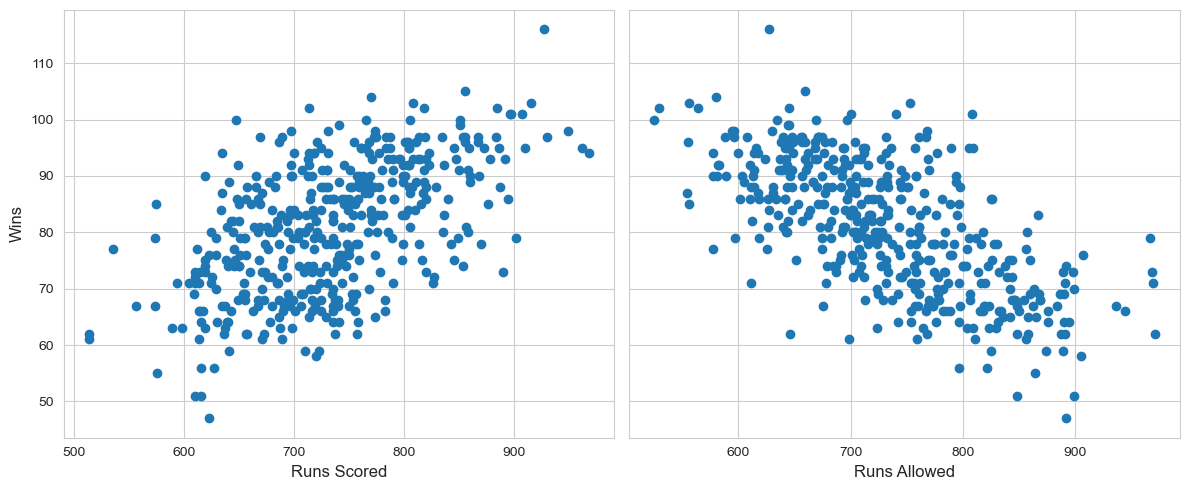

In [7]:
fig,ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

ax[0].scatter(bb_train.R, 
              bb_train.W)
ax[0].set_ylabel("Wins", fontsize=12)
ax[0].set_xlabel("Runs Scored", fontsize=12)


ax[1].scatter(bb_train.RA,
              bb_train.W)
ax[1].set_xlabel("Runs Allowed", fontsize=12)

plt.tight_layout()

plt.show()

Both of these look to be linear relationships, which is an important check for our choice in simple linear regression. If it did not look as though there was a linear relationship, we would not use simple linear regression. 

In real modeling projects there is more data exploration, but for this notebook we will continue on.

#### Step 4. Comparing different models on the training set

We will try the following models

$$
\text{Model 1: } \ \ \texttt{W} = \beta_0 + \beta_1 \texttt{R} + \epsilon,
$$

$$
\text{Model 2: } \ \ \texttt{W} = \beta_0 + \beta_1 \texttt{RA} + \epsilon.
$$

$$
\text{Model 3: } \ \ \texttt{W} = \beta_0 + \beta_1 \texttt{R} + \beta_2 \texttt{RA} + \epsilon.
$$

$$
\text{Model 4: kNN using R and RA as features with k=10} 
$$

Note 1:  We would usually perform some form of hyperparameter tuning to decide on the value of $k$ in kNN but we are simplifying things for illustrative purposes.

Note 2: kNN might be good at prediction, but a downside is that we will loose interpret-ability and the ability to extrapolate to more unusual input values.

##### Identifying a baseline model

In predictive modeling problems it is also smart to have a <i>baseline model</i>. A baseline model is a simple model that exists for comparison purposes. These are important because they allow us to put our model results into context. For example, we may end up with an MSE of $100$. Is that good? Is that bad? In the abstract it is impossible to tell. It is only when we have a reasonable baseline model that we are able to put into context how good our performance is. Again for example, if our baseline model's MSE was $1000$ our model with MSE$=100$ has done quite well, but if our baseline model's MSE was $10$ our model has underperformed the baseline.

Moreover, merely outperforming the baseline is not always an indication of the best model. We also need to consider things like training time, model complexity and interpretability. While those will not be considerations in this notebook, they will become more important as we progress through these notebooks and in your own data science projects.

For this problem a standard first baseline is to predict the average value of the output, $\overline{\texttt{W}}$, for any value of the input. This brings us to three models:

$$
\text{Model 0: } \ \ \texttt{W} = E\left(\texttt{W}\right) + \epsilon.
$$

Now that we have our models, let's implement cross-validation. The code below will have missing pieces, I encourage you to try and fill them out on your own.

In [8]:
## Import KFold
from sklearn.model_selection import KFold

In [9]:
## Make a KFold object with k=5
kfold = KFold(5, shuffle = True, random_state = 440)

We will look for the model with the lowest mean square error. We could calculate this by hand, but we will use `sklearn`'s `mean_squared_error` instead, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html</a>

In [10]:
## importing mean_squared_error
from sklearn.metrics import mean_squared_error

In [11]:
## import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [12]:
bb_train[['R','RA']]

,R,RA
111,840,781
151,849,805
163,766,732
140,807,726
439,694,729
...,...,...
487,818,564
430,729,618
399,757,705
397,669,653


Now we are ready to perform cross-valdiation. Again there will be some empty spots that you can fill in on your own if you would like.

In [14]:
## make an array of zeros that will hold our mses
mses = np.zeros((5, 5))

## This keeps track of what split we are on
i = 0
## fill in what is missing in the for loop declaration
for i,(train_index, test_index) in enumerate(kfold.split(bb_train)):
    ## now we get the training splits and the holdout split
    ### Training
    bb_tt = bb_train.iloc[train_index]
    
    ### Holdout set
    bb_ho = bb_train.iloc[test_index]
    
    
    ### This is Model 0 ###
    ## take the mean W from the training set
    ## we need predictions for the entire holdout set
    pred0 = bb_tt.W.mean() * np.ones(len(bb_ho))
    

    model1 = LinearRegression()
    model2 = LinearRegression()
    model3 = LinearRegression()
    model4 = KNeighborsRegressor(n_neighbors = 10)

    ## fit models on the training data, bb_tt
    ## don't forget you may need to reshape the data for simple linear regressions
    model1.fit(bb_tt.R.values.reshape(-1,1), bb_tt.W.values)
    model2.fit(bb_tt.RA.values.reshape(-1,1), bb_tt.W.values)

    # No need to reshape inputs for model3 or model4
    model3.fit(bb_tt[['R','RA']], bb_tt.W.values)
    model4.fit(bb_tt[['R','RA']], bb_tt.W.values)

    
    ## get the prediction on holdout set
    pred1 = model1.predict(bb_ho.R.values.reshape(-1,1))
    pred2 = model2.predict(bb_ho.RA.values.reshape(-1,1))
    pred3 = model3.predict(bb_ho[['R','RA']])
    pred4 = model4.predict(bb_ho[['R','RA']])

    
    ### Recording the MSES ###
    ## mean_squared_error takes in the true values, then the predicted values
    mses[0,i] = mean_squared_error(bb_ho.W.values, pred0)
    mses[1,i] = mean_squared_error(bb_ho.W.values, pred1)
    mses[2,i] = mean_squared_error(bb_ho.W.values, pred2)
    mses[3,i] = mean_squared_error(bb_ho.W.values, pred3)
    mses[4,i] = mean_squared_error(bb_ho.W.values, pred4)

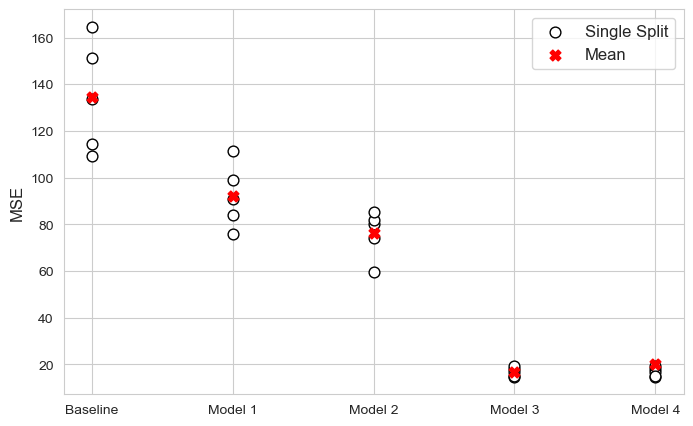

In [21]:
## This figure will compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
plt.scatter(np.ones(5), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')
plt.scatter(2*np.ones(5), 
            mses[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter(3*np.ones(5), 
            mses[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter(4*np.ones(5), 
            mses[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter([0,1,2,3,4], 
            np.mean(mses, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2,3, 4],["Baseline", "Model 1", "Model 2", "Model 3", "Model 4"], fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("MSE", fontsize=12)

plt.show()

In [22]:
np.mean(mses, axis=1)

array([134.72066834,  92.17918775,  76.19033069,  16.81447445,
        20.19290323])

From this it appears that Model 3 is our best choice as it has the lowest average cross-validation MSE.

#### Step 5. Final sanity check on test set

Remember that you **only test your final model on the test set**.  Don't try your other models on the test set.

Once you are done tinkering and have settled on a final model (or a final set of a few models) you can perform your final check with the test set. The purposes of this check are twofold:
1. We will be able to see if we had any coding errors in our work up to this point, performance that greatly departs from what we would expect may indicate a coding error in our earlier work and
2. It allows us to assess overfitting (more on this soon). When our test performance is significantly worse than our training performance it suggests that our model has overfit on the training data and will not generalize well.

If you notice weird behavior on the test set it may be worth reviewing your previous work and checking out different models.

In [23]:
## Make a final model object
model = LinearRegression()

In [24]:
## fit that on the entire training set
model.fit(bb_train[['R','RA']], bb_train.W.values)

LinearRegression()

In [25]:
## print the training set performance
print("Training set RMSE:", 
      np.round(np.sqrt(mean_squared_error(bb_train.W.values, model.predict(bb_train[['R','RA']]))),2))


## print the test set performance
print("Test set RMSE:", 
      np.round(np.sqrt(mean_squared_error(bb_test.W.values, model.predict(bb_test[['R','RA']]))),2))

Training set RMSE: 4.07
Test set RMSE: 4.09


These are comparable performances, so I think we are in the clear for over-fitting and coding errors.

In [26]:
# Interpretation of the model
print(f"Each additional run scored increases our predicted number of wins by {model.coef_[0]}")
print(f"Each additional run allowed decreases our predicted number of wins by {-model.coef_[1]}")

Each additional run scored increases our predicted number of wins by 0.09759777857549456
Each additional run allowed decreases our predicted number of wins by 0.10268800304130332


These are really close so we cannot clearly say whether we should focus more on offense or defense.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)